In [ ]:
#Instala la librería de Kaggle
!pip install kaggle

# 2. Sube tu archivo kaggle.json
print("Por favor, sube tu archivo 'kaggle.json' que descargaste desde tu cuenta de Kaggle.")
from google.colab import files
files.upload()

#Mueve el archivo a la ubicación correcta
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("\n¡API de Kaggle configurada!")

Por favor, sube tu archivo 'kaggle.json' que descargaste desde tu cuenta de Kaggle.


Saving kaggle.json to kaggle.json

¡API de Kaggle configurada!


In [ ]:
# Celda de limpieza
print("Limpiando directorios antiguos...")
!rm -rf train/
!rm -rf data/
!rm -f train.zip
!rm -f test1.zip

print("¡Limpieza completada! Ahora puedes continuar.")

Limpiando directorios antiguos...
¡Limpieza completada! Ahora puedes continuar.


In [ ]:
#Descarga el dataset de la competición "Dogs vs. Cats"
!kaggle competitions download -c dogs-vs-cats --force

print("\nDataset descargado. Descomprimiendo archivos...")

#Descomprime el archivo principal (dogs-vs-cats.zip)
print("Descomprimiendo dogs-vs-cats.zip...")
!unzip -q dogs-vs-cats.zip

#descomprime train.zip y test1.zip
print("Descomprimiendo train.zip...")
!unzip -q train.zip

print("Descomprimiendo test1.zip...")
!unzip -q test1.zip

print("\n¡Todos los archivos descomprimidos!")

 99% 807M/812M [00:07<00:00, 78.4MB/s]
100% 812M/812M [00:07<00:00, 119MB/s] 

Dataset descargado. Descomprimiendo archivos...
Descomprimiendo dogs-vs-cats.zip...
Descomprimiendo train.zip...
Descomprimiendo test1.zip...

¡Todos los archivos descomprimidos!


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

print("Creando estructura de carpetas...")

# --- Configuración ---
BASE_DIR = 'data/'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALIDATION_DIR = os.path.join(BASE_DIR, 'validation')

# Directorios de clases (Perros y Gatos)
TRAIN_CATS_DIR = os.path.join(TRAIN_DIR, 'cats')
TRAIN_DOGS_DIR = os.path.join(TRAIN_DIR, 'dogs')
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, 'cats')
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, 'dogs')

#Crear directorios base
os.makedirs(TRAIN_CATS_DIR, exist_ok=True)
os.makedirs(TRAIN_DOGS_DIR, exist_ok=True)
os.makedirs(VALIDATION_CATS_DIR, exist_ok=True)
os.makedirs(VALIDATION_DOGS_DIR, exist_ok=True)

#Obtener la lista de todas las imágenes de entrenamiento
original_train_dir = 'train/'
all_filenames = os.listdir(original_train_dir)

#Separar por nombre (cat vs dog)
cat_filenames = [f for f in all_filenames if f.startswith('cat')]
dog_filenames = [f for f in all_filenames if f.startswith('dog')]

#Dividir en entrenamiento y validación (usaremos 20% para validación)

# Tomamos 8000 gatos y 8000 perros
cat_filenames = cat_filenames[:8000]
dog_filenames = dog_filenames[:8000]

train_cats, val_cats = train_test_split(cat_filenames, test_size=0.2, random_state=42)
train_dogs, val_dogs = train_test_split(dog_filenames, test_size=0.2, random_state=42)

#Función para copiar archivos
def copy_files(filenames, source_dir, destination_dir):
    for f in filenames:
        src = os.path.join(source_dir, f)
        dst = os.path.join(destination_dir, f)
        shutil.copyfile(src, dst)

#Copiar los archivos a las nuevas carpetas
print("Copiando archivos de entrenamiento y validación...")
copy_files(train_cats, original_train_dir, TRAIN_CATS_DIR)
copy_files(train_dogs, original_train_dir, TRAIN_DOGS_DIR)
copy_files(val_cats, original_train_dir, VALIDATION_CATS_DIR)
copy_files(val_dogs, original_train_dir, VALIDATION_DOGS_DIR)

print("\n¡Estructura de datos lista!")
print(f"Total imágenes de entrenamiento (gatos): {len(os.listdir(TRAIN_CATS_DIR))}")
print(f"Total imágenes de entrenamiento (perros): {len(os.listdir(TRAIN_DOGS_DIR))}")
print(f"Total imágenes de validación (gatos): {len(os.listdir(VALIDATION_CATS_DIR))}")
print(f"Total imágenes de validación (perros): {len(os.listdir(VALIDATION_DOGS_DIR))}")

Creando estructura de carpetas...
Copiando archivos de entrenamiento y validación...

¡Estructura de datos lista!
Total imágenes de entrenamiento (gatos): 6400
Total imágenes de entrenamiento (perros): 6400
Total imágenes de validación (gatos): 1600
Total imágenes de validación (perros): 1600


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Preparar los Generadores de Imágenes ---
#Redimensionamos todas las imágenes a 150x150
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

#Normalizamos los píxeles (de 0-255 a 0-1)
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'  # Porque es clasificación binaria (perro o gato)
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# --- Construir la Red Neuronal Convolucional (CNN) simple ---
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2, 2),
    # Añadimos Dropout después de cada bloque Conv/Pool

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25), # Apaga el 25% de las neuronas de la capa anterior

    Flatten(),

    # Añadimos Dropout después de la capa Densa
    Dense(512, activation='relu'),
    Dropout(0.5), # Apaga el 50% de las neuronas (más agresivo aquí)

    Dense(1, activation='sigmoid')
])

# --- Compilar el Modelo ---
model.compile(optimizer='adam',
              loss='binary_crossentropy', # Pérdida para binarios
              metrics=['accuracy'])

model.summary()

Found 12800 images belonging to 2 classes.
Found 3200 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- Entrenar el Modelo ---
EPOCHS = 30

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator), # batches por epoch
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator) # batches por epoch de validación
)

print("\n¡Entrenamiento completado!")

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


400/400 ━━━━━━━━━━━━━━━━━━━━ 34s 68ms/step - accuracy: 0.5742 - loss: 0.7214 - val_accuracy: 0.7184 - val_loss: 0.5473
Epoch 2/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - accuracy: 0.7235 - loss: 0.5444 - val_accuracy: 0.7053 - val_loss: 0.5463
Epoch 3/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - accuracy: 0.7712 - loss: 0.4727 - val_accuracy: 0.7775 - val_loss: 0.4625
Epoch 4/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.8098 - loss: 0.4131 - val_accuracy: 0.8012 - val_loss: 0.4349
Epoch 5/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.8405 - loss: 0.3577 - val_accuracy: 0.8116 - val_loss: 0.4305
Epoch 6/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.8768 - loss: 0.2832 - val_accuracy: 0.8225 - val_loss: 0.4141
Epoch 7/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 25s 64ms/step - accuracy: 0.9149 - loss: 0.2195 - val_accuracy: 0.8166 - val_loss: 0.4474
Epoch 8/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.9445 - loss: 0.1496 - val_accurac

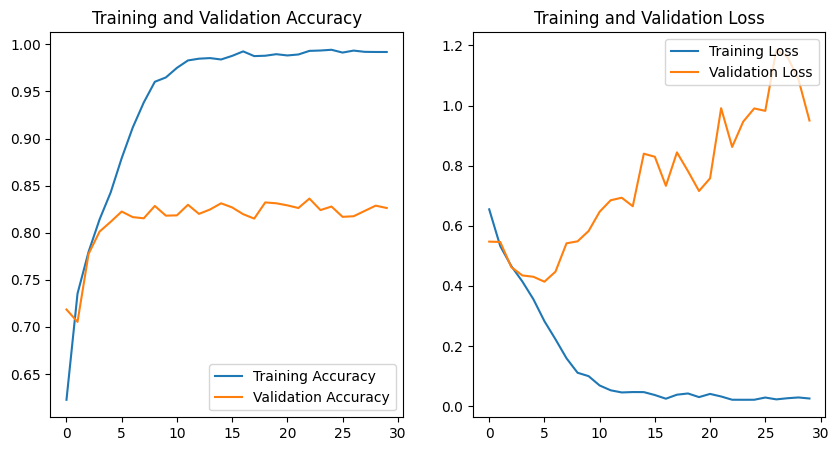

In [ ]:
import matplotlib.pyplot as plt

# Obtener métricas del historial de entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

# Graficar Precisión
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Graficar Pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Por favor, sube una imagen de un perro o un gato para la predicción:


Saving trece.jpg to trece.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step

Índices de clases: {'cats': 0, 'dogs': 1}


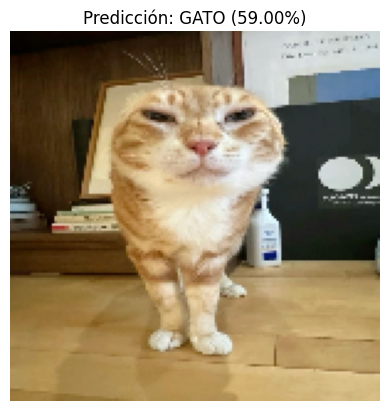

La puntuación cruda (sigmoid) fue: 0.4100
El modelo predice que esto es un: GATO con un 59.00% de confianza.


In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Subir la imagen
print("Por favor, sube una imagen de un perro o un gato para la predicción:")
uploaded = files.upload()

# Iterar sobre los archivos subidos (normalmente solo será uno)
for filename in uploaded.keys():

  # Cargar y pre-procesar la imagen
  img = image.load_img(
      filename,
      target_size=(IMG_HEIGHT, IMG_WIDTH) # Usamos las variables IMG_HEIGHT y IMG_WIDTH de antes
  )

  # Convertir la imagen a un array de numpy
  img_array = image.img_to_array(img)

  # Normalizar la imagen (igual que en el entrenamiento)
  img_array = img_array / 255.0

  # Añadir una dimensión extra para crear un "batch" de 1 imagen
  # El modelo espera una forma de (batch_size, height, width, channels)
  # Así que cambiamos de (150, 150, 3) a (1, 150, 150, 3)
  img_batch = np.expand_dims(img_array, axis=0)

  # Realizar la predicción
  prediction = model.predict(img_batch)

  # Interpretar la predicción
  # La predicción es un solo número (gracias a la activación 'sigmoid')
  # Cerca de 0 significa 'clase 0'
  # Cerca de 1 significa 'clase 1'

  # Verificamos qué clase es cuál (por orden alfabético: cats=0, dogs=1)
  print(f"\nÍndices de clases: {train_generator.class_indices}")

  score = prediction[0][0]
  if score > 0.5:
      result = "PERRO"
      confidence = score * 100
  else:
      result = "GATO"
      confidence = (1 - score) * 100

  # Mostrar el resultado
  plt.imshow(img)
  plt.title(f"Predicción: {result} ({confidence:.2f}%)")
  plt.axis('off')
  plt.show()

  print(f"La puntuación cruda (sigmoid) fue: {score:.4f}")
  print(f"El modelo predice que esto es un: {result} con un {confidence:.2f}% de confianza.")

In [ ]:
# Define el nombre del archivo para tu modelo
model_filename = 'clasificador_perros_gatos_v2.h5'

# Guarda el modelo
model.save(model_filename)

print(f"¡Modelo guardado exitosamente en Colab con el nombre: {model_filename}!")

¡Modelo guardado exitosamente en Colab con el nombre: clasificador_perros_gatos_v2.h5!
